In [1]:
train_dir_LandSAT = r"C:\Users\HPCL\OneDrive - University of New Orleans\Documents\Research\Year 1\Pytorch\Year1_Research\New Experimets\Data\Landsat 30m Resolution"
train_dir_Sentinel = r"C:\Users\HPCL\OneDrive - University of New Orleans\Documents\Research\Year 1\Pytorch\Year1_Research\New Experimets\Data\Sentinel uint16 Data 0%water and 0%land exclude"
save_last = r"C:\Saiful_Results\DeepLabTraining"


In [2]:

# train_dir_LandSAT = r"D:\Research\Year 1\Pytorch\Year1_Research\New Experimets\Data\Landsat 30m Resolution"
# train_dir_Sentinel = r"D:\Research\Year 1\Pytorch\Year1_Research\New Experimets\Data\Sentinel uint16 Data 0%water and 0%land exclude"


In [3]:
import time

today=str(time.ctime().replace(":","-").replace(" ","-"))
print(today)

save_last = save_last+"\\"+today
    
print(save_last)

Fri-Apr-14-16-29-57-2023
C:\Saiful_Results\DeepLabTraining\Fri-Apr-14-16-29-57-2023


In [4]:
import os



if not os.path.exists(save_last):
    os.makedirs(save_last) 
    
    
    

In [5]:
import numpy as np
import matplotlib.pyplot as plt
# import os
import copy
import sys
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from PIL import Image
from collections import OrderedDict
import pandas as pd
from tqdm import tqdm
import random
from collections import defaultdict 
import tifffile as tiff
import imageio as io
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import segmentation_models_pytorch as smp
from skimage.morphology import binary_dilation, binary_erosion
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.metrics import average_precision_score

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Loss Functions

In [7]:
def weighted_bce_loss(output,y,weight):
    epsilon= 1e-7
    output = torch.clamp(output, epsilon, 1.-epsilon)
    logit_output = torch.log(output/(1.-output))
    
    loss = (1.-y)*logit_output + (1.+(weight-1.)*y) * (torch.log(1.+torch.exp(-torch.abs(logit_output))) + torch.maximum(-logit_output,torch.tensor(0.).cuda()))
    return torch.sum(loss)/torch.sum(weight)

def weighted_dice_loss(output,y,weight):
    smooth = 1.
    w,m1,m2 = weight*weight, y, output
    intersection = (m1*m2)
    score = (2.*torch.sum(w*intersection)+smooth)/(torch.sum(w*m1)+torch.sum(w*m2)+smooth)
    loss  = 1.-torch.sum(score)
    return loss

def iou_loss(y_pred, y_true, weight):
    weight = weight*weight
    intersection = y_true * y_pred
    not_true     = 1 - y_true
    union        = y_true + (not_true * y_pred)
    iou          = (torch.sum(intersection * weight)) / (torch.sum(union * weight))

    loss = 1-iou
    return loss
    

def border_loss(output,y,pool_size=(9,9), pad=(4,4)):
    y      = y.type(torch.float32)
    
    output = output.type(torch.float32)
    
    averaged_mask = F.avg_pool2d(y,kernel_size=pool_size,stride=(1,1), padding=pad)
    border = (averaged_mask>0.005).type(torch.float32) * (averaged_mask<0.995).type(torch.float32)
    weight = torch.ones_like(averaged_mask)
    w0     = torch.sum(weight)
    weight+= border*2
    w1     = torch.sum(weight)
    weight*= (w0/w1)
    loss   = weighted_bce_loss(output,y,weight) + weighted_dice_loss(output,y,weight) + iou_loss(output,y,weight)
    return loss

# Functions

In [8]:
################ Metrics #######################
def IoU_pr_rec_f1(y_true, y_pred):
    
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    y_pred = ((y_pred)*1.).type(torch.float32)
    
    tp = torch.sum(y_true*(y_pred))
    tn = torch.sum((1-y_true)*((1-y_pred)))
    fp = torch.sum((1-y_true)*(y_pred))
    fn = torch.sum((y_true)*((1-y_pred)))
    
    pr  = (tp/(tp+fp))
    rec = (tp/(tp+fn))
    f1  = ((2*pr*rec)/(pr+rec))
    tnr = (tn/(tn+fp))
    fpr = (fp/(fp+tn))
    
    intersection = y_true*y_pred
    not_true     = 1 - y_true
    union        = y_true + (not_true * y_pred)
    iou         = (torch.sum(intersection)) / (torch.sum(union))
    
    return iou, pr, rec, f1, tnr, fpr

# Saving Metrics
def metrics():
    x = np.arange(0,1,0.05)
    IoU_      = []
    threshold = []
    precision = []
    recall    = []
    F_score   = []
    mF_score  = []
    TNR       = []
    FPR       = []
    name_list = []

    dict_1 = {'Threshold': threshold,
              'Name':name_list,
              'IoU':IoU_,
              'Precision':precision,
              'Recall':recall,
              'F-Score':F_score,
              'mF-Score':mF_score,
              'True Negative Rate':TNR,
              'False Positive Rate':FPR}
    return dict_1

def best_f_score(name, test_masks, predictions) :
    dict_1 = metrics()
    y = 0
    outer = 0
    check = 0
    x = 0 
    y = 1
    while outer<3:    
        if y>1:
            m = y-1
            y-= m
        z = np.linspace(x, y, 21)
        for i in z:
#             print(i)
            y_true = torch.from_numpy(test_masks)
            y_pred = torch.from_numpy((predictions>i)*1)

            tp = torch.sum(y_true*(y_pred),dim=[1,2,3])
            tn = torch.sum((1-y_true)*((1-y_pred)),dim=[1,2,3])
            fp = torch.sum((1-y_true)*(y_pred),dim=[1,2,3])
            fn = torch.sum((y_true)*((1-y_pred)),dim=[1,2,3])

            pr  = (tp/(tp+fp))
            rec = (tp/(tp+fn))
            score  = ((2*pr*rec)/(pr+rec))
            idx    = torch.isnan(score)
            score[idx] = 0
            score  = torch.sum(score)/len(X_test)
            
            a,b,c,d,e,f = IoU_pr_rec_f1(torch.from_numpy(test_masks), torch.from_numpy(predictions>i))
            dict_1['IoU'].append(a.numpy())
            dict_1['Threshold'].append(i)
            dict_1['Precision'].append(b.numpy())
            dict_1['Recall'].append(c.numpy())
            dict_1['F-Score'].append(d.numpy())
            dict_1['mF-Score'].append(score.cpu().detach().numpy())
            dict_1['True Negative Rate'].append(e.numpy())
            dict_1['False Positive Rate'].append(f.numpy())
            dict_1['Name'].append(name)
            if d>check:
                check = d
                x = i
            else:
                pass
        if outer == 0:
            y = x+0.1
        elif outer==1:
            y = x+0.01
        outer+=1
    
    df = pd.DataFrame(dict_1)
    df = df.sort_values(by=['F-Score'], ascending=False)
    df = df.iloc[0:1]
    
    AP = average_precision_score(test_masks.reshape(-1), predictions.reshape(-1))
    df['AP'] = AP
        
    return df

dict_1 = metrics()

# Load Labeled Data

In [9]:
X_train_LandSAT = np.load(r"{}\X_train_4500_30m_res.npy".format(train_dir_LandSAT))
X_val_LandSAT   = np.load(r"{}\X_val_500_30m_res.npy".format(train_dir_LandSAT))
X_test_LandSAT  = np.load(r"{}\X_test_2000_30m_res.npy".format(train_dir_LandSAT))

Y_train_LandSAT = (X_train_LandSAT[...,1]-X_train_LandSAT[...,3])/(X_train_LandSAT[...,1]+X_train_LandSAT[...,3])
Y_val_LandSAT   = (X_val_LandSAT[...,1]-X_val_LandSAT[...,3])/(X_val_LandSAT[...,1]+X_val_LandSAT[...,3])
Y_test_LandSAT  = (X_test_LandSAT[...,1]-X_test_LandSAT[...,3])/(X_test_LandSAT[...,1]+X_test_LandSAT[...,3])

Y_train_LandSAT = ((Y_train_LandSAT<1.)*1).astype('float32')
Y_val_LandSAT   = ((Y_val_LandSAT<1.)*1).astype('float32')
Y_test_LandSAT  = ((Y_test_LandSAT<1.)*1).astype('float32')

X_train_LandSAT = X_train_LandSAT[...,2::-1].copy()
X_val_LandSAT   = X_val_LandSAT[...,2::-1].copy()
X_test_LandSAT  = X_test_LandSAT[...,2::-1].copy()

X_train_LandSAT = X_train_LandSAT - X_train_LandSAT.min(axis=(1,2), keepdims=True) 
X_val_LandSAT   = X_val_LandSAT  - X_val_LandSAT.min(axis=(1,2), keepdims=True)
X_test_LandSAT  = X_test_LandSAT - X_test_LandSAT.min(axis=(1,2), keepdims=True) 

X_train_LandSAT = X_train_LandSAT / X_train_LandSAT.max(axis=(1,2), keepdims=True) 
X_val_LandSAT   = X_val_LandSAT  / X_val_LandSAT.max(axis=(1,2), keepdims=True)
X_test_LandSAT  = X_test_LandSAT / X_test_LandSAT.max(axis=(1,2), keepdims=True) 

C:\Users\HPCL\AppData\Local\Temp\ipykernel_16164\3036067045.py:5: RuntimeWarning: invalid value encountered in true_divide
  Y_train_LandSAT = (X_train_LandSAT[...,1]-X_train_LandSAT[...,3])/(X_train_LandSAT[...,1]+X_train_LandSAT[...,3])
C:\Users\HPCL\AppData\Local\Temp\ipykernel_16164\3036067045.py:7: RuntimeWarning: invalid value encountered in true_divide
  Y_test_LandSAT  = (X_test_LandSAT[...,1]-X_test_LandSAT[...,3])/(X_test_LandSAT[...,1]+X_test_LandSAT[...,3])


In [10]:
## SENTINEL DATA

In [11]:
np.random.seed(49)
pop = np.arange(5121)
sample_train = np.random.choice(pop, 4608, replace=False)
sample_val  = np.delete(pop, sample_train)
len(sample_train), len(sample_val)

(4608, 513)

In [12]:
X_sen      = np.load(r"{}\X_train_sentinel_6_channles_5121.npy".format(train_dir_Sentinel))
X_test_sen = np.load(r"{}\X_test_sentinel_6_channles_2053.npy".format(train_dir_Sentinel))
X_train_sen= X_sen[sample_train]
X_val_sen  = X_sen[sample_val]

Y_train_sen         = (X_train_sen[...,1]-X_train_sen[...,3])/(X_train_sen[...,1]+X_train_sen[...,3])
Y_val_sen           = (X_val_sen[...,1]-X_val_sen[...,3])/(X_val_sen[...,1]+X_val_sen[...,3])
Y_test_sen         = (X_test_sen[...,1]-X_test_sen[...,3])/(X_test_sen[...,1]+X_test_sen[...,3])

Y_train_sen         = ((Y_train_sen<1.)*1).astype('float32')
Y_val_sen           = ((Y_val_sen<1.)*1).astype('float32')
Y_test_sen          = ((Y_test_sen<1.)*1).astype('float32')

X_train_sen         = X_train_sen[...,2::-1].copy()
X_val_sen           = X_val_sen[...,2::-1].copy()
X_test_sen          = X_test_sen[...,2::-1].copy()

X_train_sen         = np.clip(X_train_sen, 0, 3558) 
X_val_sen           = np.clip(X_val_sen, 0, 3558)
X_test_sen          = np.clip(X_test_sen, 0, 3558) 

X_train_sen         = (X_train_sen / 3558).astype(np.float32) 
X_val_sen           = (X_val_sen  / 3558).astype(np.float32)
X_test_sen          = (X_test_sen / 3558).astype(np.float32) 

Y_train_sen.shape

(4608, 128, 128)

In [13]:
Y_test= Y_test_sen # np.concatenate((Y_test_LandSAT,Y_test_sen),axis = 0)
Y_test.shape

(2053, 128, 128)

In [14]:
# Contours for Sentinel

In [15]:
Y_train_sen  = np.array([binary_dilation(binary_dilation(mask))-mask for mask in Y_train_sen], dtype='float64')
Y_val_sen   = np.array([binary_dilation(binary_dilation(mask))-mask for mask in Y_val_sen], dtype='float64')
Y_test_sen  = np.array([binary_dilation(binary_dilation(mask))-mask for mask in Y_test_sen], dtype='float64')

In [16]:
from sklearn.utils import shuffle
X_sen, Y_sen = shuffle(X_train_sen, Y_train_sen, random_state=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


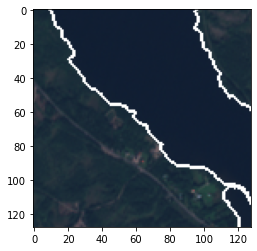

In [17]:
plt.imshow(X_sen[0]+Y_sen[0,...,np.newaxis])

In [18]:
# Contours for LandSAT

In [19]:
Y_train_LandSAT  = np.array([binary_dilation(mask)-mask for mask in Y_train_LandSAT], dtype='float64')
Y_val_LandSAT   = np.array([binary_dilation(mask)-mask for mask in Y_val_LandSAT], dtype='float64')
Y_test_LandSAT  = np.array([binary_dilation(mask)-mask for mask in Y_test_LandSAT], dtype='float64')

In [20]:
X_LS, Y_LS = shuffle(X_train_LandSAT, Y_train_LandSAT, random_state=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


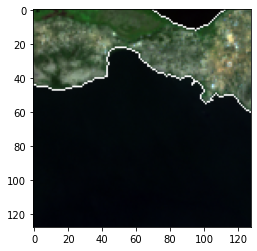

In [21]:
plt.imshow(X_LS[0]+Y_LS[0,...,np.newaxis])

In [22]:
# Concatenate the inputs and labels#

In [23]:
X_train = np.concatenate((X_LS,X_sen),axis = 0)
print(X_train.shape)

X_val = np.concatenate((X_val_LandSAT,X_val_sen),axis = 0)
print(X_val.shape)

X_test = np.concatenate((X_test_LandSAT,X_test_sen),axis = 0)
print(X_test.shape)

(9108, 128, 128, 3)
(1013, 128, 128, 3)
(4053, 128, 128, 3)


In [24]:
Y_train=  np.concatenate((Y_LS,Y_sen),axis = 0)
print(Y_train.shape)

Y_val=  np.concatenate((Y_val_LandSAT,Y_val_sen),axis = 0)
print(Y_val.shape)

Y_test=  np.concatenate((Y_test_LandSAT,Y_test_sen),axis = 0)
print(Y_test.shape)

(9108, 128, 128)
(1013, 128, 128)
(4053, 128, 128)


In [25]:
# shuffle the training data

In [26]:
X, Y = shuffle(X_train, Y_train, random_state=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


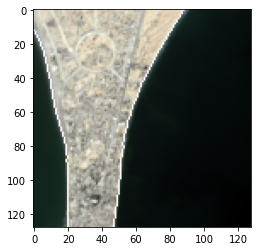

In [27]:
plt.imshow(X[0]+Y[0,...,np.newaxis])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


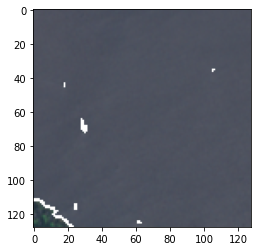

In [28]:
plt.imshow(X_val[1002]+Y_val[1002,...,np.newaxis])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


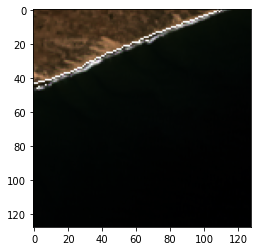

In [29]:
plt.imshow(X_test[1000]+Y_test[1000,...,np.newaxis])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


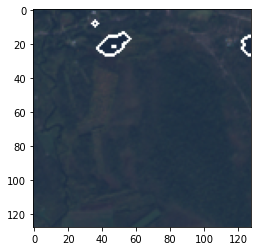

In [30]:
plt.imshow(X_test[2000]+Y_test[2000,...,np.newaxis])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


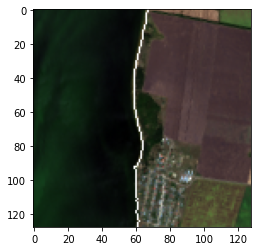

In [31]:
plt.imshow(X_test[1500]+Y_test[1500,...,np.newaxis])

# Pytorch DataLoaders

In [32]:
class NDWIDataset(Dataset):

    def __init__(self, images, masks, transform=None, test_transform=None):
        self.images     = images
        self.masks      = masks
        self.transforms = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        
        image = self.images[idx]
        mask = self.masks[idx]

        if self.transforms:
            augmentations = self.transforms(image=image, mask=mask)
        
        image = augmentations['image']
        mask  = augmentations['mask']
        mask  = mask[np.newaxis,:,:]
        
        return [image.type(torch.float32), 
                mask.type(torch.float32)]
        

In [33]:
class NDWIDataset_pseudo(Dataset):

    def __init__(self, imgs, model_pred, threshold=None, transform=None, test_transform=None):
        self.image   = imgs
        self.model   = model_pred
        self.transforms = transform
        self.threshold  = threshold

    def __len__(self):
        return len(self.image)
    
    def __getitem__(self, idx):
        image = self.image[idx].astype('float32')
        model = self.model
        image= image[...,2::-1].copy()
        image= image - image.min(axis=(0,1))
        image= image / image.max(axis=(0,1))
        
        if self.transforms:
            augmentations = self.transforms(image=image)
        
        image = augmentations['image']
        mask  = ((model(image[np.newaxis].cuda()).cpu().detach())>self.threshold)*1.
        mask  = mask.squeeze()
        mask  = mask[np.newaxis,:,:]
        
        return [image.type(torch.float32), 
                mask.type(torch.float32)]
        

In [34]:
class NDWIDataset_from_dir(Dataset):

    def __init__(self, img_dir, model_pred, threshold=None, transform=None, test_transform=None):
        self.dir     = img_dir
        self.model   = model_pred
        self.transforms = transform
        self.threshold  = threshold

    def __len__(self):
        return len(self.dir)
    
    def __getitem__(self, idx):
        path = self.dir[idx]
        model = self.model
        image= (tiff.imread(path)).astype('float32')
        image= image[...,2::-1].copy()
        image= image - image.min(axis=(0,1))
        image= image / image.max(axis=(0,1))
        
        if self.transforms:
            augmentations = self.transforms(image=image)
        
        image = augmentations['image']
        mask  = ((model(image[np.newaxis].cuda()).cpu().detach())>self.threshold)*1.
        mask  = mask.squeeze()
        mask  = mask[np.newaxis,:,:]
        
        return [image.type(torch.float32), 
                mask.type(torch.float32)]

In [35]:
class NDWIDataset_from_dir_reg(Dataset):

    def __init__(self, img_dir, transform=None, test_transform=None):
        self.dir     = img_dir
        self.transforms = transform

    def __len__(self):
        return len(self.dir)
    
    def __getitem__(self, idx):
        eps  = 1e-7
        path = self.dir[idx]
        image= (tiff.imread(path)).astype('float32')
        mask = (((image[...,1]-image[...,3] +eps)/(image[...,1]+image[...,3] +eps))>0).astype('float32')
        mask = binary_dilation(mask)-mask
        
        image= image[...,2::-1].copy()
        image= (image) - (image.min(axis=(0,1)))
        image= (image+eps) / (image.max(axis=(0,1))+eps)
        
        if self.transforms:
            augmentations = self.transforms(image=image, mask=mask)
        
        image = augmentations['image']
        mask = augmentations['mask']
        mask = mask[np.newaxis,:,:]
        
        
        return [image.type(torch.float32), 
                mask.type(torch.float32)]        

In [36]:
def data(trans, trans_test, X_train, Y_train, X_val, Y_val, X_test, Y_test, split=0.9, val=True, batch_size=16):
    torch.manual_seed(49)
    random.seed(49)
    trainset= NDWIDataset(X_train, Y_train, transform=trans)

    if val:
        print(f'Training:{len(X_train)}, Validation:{len(X_val)}')
        print(f'Testing: {len(X_test)}')
        
        valset  = NDWIDataset(X_val, Y_val, transform=trans_test)
        testset = NDWIDataset(X_test, Y_test, transform=trans_test)
        image_datasets = {'train': trainset, 'val': valset, 'test': testset}
        batch_size = batch_size

        dataloaders = {
          'train': DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory = True),#, num_workers=8),
          'val': DataLoader(valset, batch_size=batch_size, shuffle=True, pin_memory = True),#, num_workers=8),
          'test': DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory = True)#, num_workers=8)
        }
        
    else:
        print(f'Training:{len(X_train)}')
        print(f'Testing: {len(X_test)}')
        testset = NDWIDataset(X_test, Y_test, transform=trans_test)
        image_datasets = {'train': trainset, 'test': testset}
        batch_size = batch_size

        dataloaders = {
          'train': DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory = True),#, num_workers=8),
          'test': DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory = True)#, num_workers=8)
        }
        
    
    return dataloaders

In [37]:
def data_from_dir_reg(trans, trans_test, list_train, list_val, list_test, split=0.9, factor=1, val=True, batch_size=16):
    torch.manual_seed(49)
    random.seed(49)
    trainset = NDWIDataset_from_dir_reg(list_train, transform=trans)

    if val:
#         lengths = [int(len(dataset)*split), int(len(dataset)*(1-split))+factor]
        
        valset  = NDWIDataset_from_dir_reg(list_val, transform=trans)
        testset = NDWIDataset_from_dir_reg(list_test, transform=trans_test)
        print(f'Training:{len(list_train)}, Validation:{len(list_val)}')
        print(f'Testing: {len(list_test)}')
        image_datasets = {'train': trainset, 'val': valset, 'test': testset}
        batch_size = batch_size

        dataloaders = {
          'train': DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory = True),#, num_workers=8),
          'val': DataLoader(valset, batch_size=batch_size, shuffle=True, pin_memory = True),#, num_workers=8),
          'test': DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory = True)#, num_workers=8)
        }
        
    else:
        lengths = [int(len(dataset))]
        print(f'Training:{len(list_train)}')
        print(f'Testing: {len(list_test)}')
        testset = NDWIDataset_from_dir_reg(list_test, transform=trans_test)
        image_datasets = {'train': dataset, 'test': testset}
        batch_size = batch_size

        dataloaders = {
          'train': DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory = True),#, num_workers=8),
          'test': DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory = True)#, num_workers=8)
        }
        
    
    return dataloaders

In [38]:
def data_pseudo(trans, img_paths, model, batch_size=32, split=None):
    torch.manual_seed(49)
    random.seed(49)
    if split==None:
        dataset = NDWIDataset_from_dir(img_paths, model, transform=trans)
        lengths = [int(len(dataset))]
        print(f'Pseudo-Training:{lengths[0]}')
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory = True)#, num_workers=8)
    else:
        dataset = NDWIDataset_from_dir(img_paths, model, transform=trans)
        lengths = [int(len(dataset)*split), int(len(dataset)*(1-split))+1]
        trainset, valset = torch.utils.data.random_split(dataset, lengths)
        
        print(f'Pseudo-Training, Train: {len(trainset)}, Validation: {len(valset)}')
        dataloader = {'train':DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory = True),
                      'val'  :DataLoader(valset, batch_size=batch_size, shuffle=True, pin_memory = True)}

    
    return dataloader

In [39]:
trans = A.Compose([
#     A.RandomCrop(128,128),
#     A.VerticalFlip(),
#     A.HorizontalFlip(),
    ToTensorV2()])
trans_test = A.Compose([
#              A.RandomCrop(128,128),
             ToTensorV2()])

In [40]:
def plot_rand(dataloader, set_='train'):
    if set_==None:
        for x,y in dataloader:
            x,y = x.numpy().transpose([0,2,3,1]), y.numpy().squeeze()
            break
    else:
        for x,y in dataloader[set_]:
            x,y = x.numpy().transpose([0,2,3,1]), y.numpy().squeeze()
            break
    rand = np.random.randint(0,x.shape[0])
    plt.subplot(121)
    plt.imshow(x[rand])
    plt.title('Image')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(y[rand])
    plt.title('Contour')
    plt.axis('off')
    plt.show()
#     return x,y

In [41]:
# dataloaders  = data_from_dir_reg(trans, trans_test, list_train, list_val, list_test, split=0.9)
# # dataloader_p = data_pseudo(trans, list_paths, model_pred)

# Evaluation Metrics

In [42]:
def f1_score(y_pred, y_true, threshold=0.5):
    
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)
    y_pred = ((y_pred>threshold)*1.).type(torch.float32)
    
    tp = torch.sum(y_true*(y_pred))
    tn = torch.sum((1-y_true)*((1-y_pred)))
    fp = torch.sum((1-y_true)*(y_pred))
    fn = torch.sum((y_true)*((1-y_pred)))
    
    pr  = ((tp+1.)/(tp+fp+1.))
    rec = ((tp+1.)/(tp+fn+1.))
    f1  = ((2*pr*rec)/(pr+rec))
    return f1

 Exponential MA = $V_{t} = \beta V_{t-1} + (1-\beta)(current)$

In [43]:
import time
def train_round1(model, dataloaders, loss_fn, optimizer, acc_fn, random_state=49, epochs=1):
    
    
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    torch.backends.cudnn.benchmark = True
    torch.use_deterministic_algorithms(False)
    start = time.time()                                        #Initialize time to calculate time it takes to train model
    model.to(device)                                               #Move model to GPU     

    counter=0
    train_loss, valid_loss = [], []                            #Running training and validation loss
    val_epoch, f1_epoch = [],[]
    AP_epoch =[]

    loss_list = []
    times     = []
    
    for epoch in range(epochs):
        start_epoch = time.time()
        print(f'Epoch {epoch}')
        print(scheduler.get_last_lr())
    

    #########################################Begin Model Training######################################################
    ###################################################################################################################
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()                             # Set training mode all the layers including batchnorm and dropout work in this
                dataloader = dataloaders['train']         #get the training data
            else:
                model.eval()                              # Set model to evaluate mode deactivates the batchnorm and dropout layers
                dataloader = dataloaders['val']           #get the validation data

            running_loss = 0.0                            #running loss to be used for visualization later
            step = 0                                      #Batch number
            
            if phase == 'train':  
                f1 = []
                AP = []
                for inputs, labels in dataloader:
                    x, y = inputs.to(device), labels.to(device)
                    step += 1

                    optimizer.zero_grad()                                   # zero the gradients
                    outputs = model(x)                                      #get model output for a given input

                    #################Metrics###################
                    f1.append(acc_fn(outputs, y).cpu().detach().numpy())
                    AP.append(average_precision_score(y.reshape(-1).cpu().detach().numpy(),  outputs.reshape(-1).cpu().detach().numpy()))

                    ############################################

                    ##################Calculate Loss, backprop, and update###############
                    loss           = loss_fn(outputs, y)
                    train_loss.append(loss.cpu().detach().numpy())
                    loss.backward()
                    optimizer.step()
                    print(f'Current step: {step}, AllocMem (Mb): {torch.cuda.memory_allocated()/1024/1024:.3f}, Loss: {loss:.3f},  F1: {np.mean(f1):.3f},  AP: {np.mean(AP):.3f}', end='\r') 
                    ######################################################################
        
            else:  
                loss_val = []
                f1=[]
                AP = []
                with torch.no_grad():
                    for inputs, labels in dataloader:
                        x, y = inputs.to(device), labels.to(device)
                        optimizer.zero_grad()                                   # zero the gradients
                        outputs = model(x)                                      #get model output for a given input

                        #################Metrics###################
                        f1.append(acc_fn(outputs, y).cpu().detach().numpy())
                        AP.append(average_precision_score(y.reshape(-1).cpu().detach().numpy(),  outputs.reshape(-1).cpu().detach().numpy()))

                    ############################################

                        ##################Calculate Loss, backprop, and update###############
                        valid_loss.append(loss_fn(outputs, y).cpu().detach().numpy())
                        loss_val.append(valid_loss[-1])
                val_epoch.append(np.mean(loss_val))
                f1_epoch.append(np.mean(f1))
                AP_epoch.append(np.mean(AP))
                print()
                print()
                print(f' Loss val: {val_epoch[-1]:.3f}, F-Score val:{f1_epoch[-1]:.3f}, AP val:{AP_epoch[-1]:.3f} \n') 
                ######################################################################
                

            print()
            time_elapsed = time.time() - start_epoch
            times.append(time_elapsed)
            print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
            print('-' * 10)      

        scheduler.step()
        torch.save(model, save_last+ '\\' + f'Epoch_{str(epoch).zfill(3)}'+ '.pth')
        epoch+=1
    #########################################End Model Training######################################################
    ###################################################################################################################
    
    #Total training time including time to test
    time_elapsed = time.time() - start
    print('\n Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
#     torch.save(model, save_last+ '\\' + f'Feature32_{str(1000)}_images'+ '.pth')
    
    return {'Train Loss':train_loss,
            'Valid Loss':valid_loss,
            'Times'     :times,
            'f1_epoch':f1_epoch,
            'Epochs': epoch}

## Round1(Train Using Labeled Data Only)

In [44]:
X_train_labeled = X#[:1000]
Y_train_labeled = Y#[:1000]

print(X_train_labeled.shape)

(9108, 128, 128, 3)


In [45]:
trans = A.Compose([
#    A.VerticalFlip(),
#    A.HorizontalFlip(),    
    ToTensorV2()])
trans_test = A.Compose([
                ToTensorV2()])

batch_size = 32
dataloaders = data(trans, trans_test, X_train_labeled, Y_train_labeled, X_val, Y_val, X_test, Y_test, batch_size=batch_size)

Training:9108, Validation:1013
Testing: 4053


In [46]:
# with open(r'{}historyFeature32_trainLoss.txt'.format(save_last), 'w') as f:
#     print(history['Valid Loss'], file=f)

In [47]:
def test(model, dataloaders, loss_fn, acc_fn, random_state=49, epochs=1):
    
    
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    torch.backends.cudnn.benchmark = True
    torch.use_deterministic_algorithms(False)
    start = time.time()                                        #Initialize time to calculate time it takes to train model
    model.to(device)                                               #Move model to GPU     

    model.eval()
    
    counter=0
    #train_loss,
    test_loss = []                         #Running training and validation loss
    loss_epoch, f1_epoch = [0],[0]
    AP_epoch =[0]
    loss_list = []
    times     = []
    
    for epoch in range(epochs):
        start_epoch = time.time()
        print(f'Epoch {epoch}')
        #print(scheduler.get_last_lr())
    

 ################ MODEL TESTING  #############################

        dataloader = dataloaders['test']         #get the training data

        step = 0
        loss_test = []
        f1=[]
        AP = []
        with torch.no_grad():
            for inputs, labels in dataloader:
                x, y = inputs.to(device), labels.to(device)
#                 print(y.shape)
                #optimizer.zero_grad()                                   # zero the gradients
                outputs= model(x)                                      #get model output for a given input
                
#                 print(outputs.shape)
                #################Metrics###################
                f1.append(acc_fn(outputs, y).cpu().detach().numpy())
                AP.append(average_precision_score(y.reshape(-1).cpu().detach().numpy(),  outputs.reshape(-1).cpu().detach().numpy()))
                loss_test.append(loss_fn(outputs, y).cpu().detach().numpy())
            ############################################
                print(f'Current step: {step}, AllocMem (Mb): {torch.cuda.memory_allocated()/1024/1024:.3f},  F1: {np.mean(f1):.3f},  AP: {np.mean(AP):.3f}') 

                step+=1
                ##################Calculate Loss, backprop, and update###############
               
                test_loss.append(loss_test[-1])
        loss_epoch.append(np.mean(loss_test))
        f1_epoch.append(np.mean(f1))
        AP_epoch.append(np.mean(AP))
        print()
        print()
        print(f' Loss test: {loss_epoch[-1]:.3f}, F-Score test:{f1_epoch[-1]:.3f}, AP val:{AP_epoch[-1]:.3f} \n') 
        ######################################################################
                

            

        #scheduler.step()
#         torch.save(model, save_last+ '\\' + f'Epcoh_{str(epoch).zfill(3)}'+ '.pth')
        epoch+=1
    #########################################End Model Training######################################################
    ###################################################################################################################
    
    #Total training time including time to test
    time_elapsed = time.time() - start
    print('\n Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
#     torch.save(model, save_last+ '\\' + f'Feature32_{str(1000)}_images'+ '.pth')
    
    return {
            'f1_epoch':f1_epoch,
            'Epochs': epoch}

In [48]:
batch_size = 32
dataloaders = data(trans, trans_test, X_train_labeled, Y_train_labeled, X_val, Y_val, X_test, Y_test, batch_size=batch_size)

Training:9108, Validation:1013
Testing: 4053


In [49]:



model = smp.DeepLabV3Plus(encoder_name='resnet34', encoder_weights=None, activation='sigmoid').to(device)
opt = optim.Adam(model.parameters(), lr=0.003)
scheduler = optim.lr_scheduler.MultiStepLR(opt, milestones=[100,180], gamma=0.1)

summary(model,(3,128,128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [50]:
# save_last

In [51]:
history = train_round1(model, dataloaders, loss_fn = border_loss, optimizer = opt, acc_fn = f1_score, epochs=50)

Epoch 0
[0.003]
Current step: 285, AllocMem (Mb): 357.371, Loss: 1.509,  F1: 0.302,  AP: 0.227
Training complete in 0m 55s
----------


 Loss val: 1.576, F-Score val:0.355, AP val:0.282 


Training complete in 1m 0s
----------
Epoch 1
[0.003]
Current step: 285, AllocMem (Mb): 357.621, Loss: 1.435,  F1: 0.403,  AP: 0.338
Training complete in 0m 52s
----------


 Loss val: 1.434, F-Score val:0.425, AP val:0.363 


Training complete in 0m 56s
----------
Epoch 2
[0.003]
Current step: 285, AllocMem (Mb): 357.371, Loss: 1.361,  F1: 0.434,  AP: 0.375
Training complete in 0m 51s
----------


 Loss val: 1.442, F-Score val:0.432, AP val:0.366 


Training complete in 0m 56s
----------
Epoch 3
[0.003]
Current step: 285, AllocMem (Mb): 357.621, Loss: 1.537,  F1: 0.453,  AP: 0.397
Training complete in 0m 51s
----------


 Loss val: 1.383, F-Score val:0.443, AP val:0.388 


Training complete in 0m 56s
----------
Epoch 4
[0.003]
Current step: 285, AllocMem (Mb): 357.371, Loss: 1.282,  F1: 0.467,  AP: 

Current step: 285, AllocMem (Mb): 357.371, Loss: 1.067,  F1: 0.591,  AP: 0.554
Training complete in 0m 46s
----------


 Loss val: 1.289, F-Score val:0.514, AP val:0.459 


Training complete in 0m 50s
----------
Epoch 37
[0.003]
Current step: 285, AllocMem (Mb): 357.621, Loss: 1.241,  F1: 0.594,  AP: 0.557
Training complete in 0m 46s
----------


 Loss val: 1.223, F-Score val:0.548, AP val:0.506 


Training complete in 0m 50s
----------
Epoch 38
[0.003]
Current step: 285, AllocMem (Mb): 357.371, Loss: 1.193,  F1: 0.599,  AP: 0.563
Training complete in 0m 46s
----------


 Loss val: 1.427, F-Score val:0.437, AP val:0.376 


Training complete in 0m 50s
----------
Epoch 39
[0.003]
Current step: 285, AllocMem (Mb): 357.621, Loss: 1.092,  F1: 0.600,  AP: 0.565
Training complete in 0m 46s
----------


 Loss val: 1.216, F-Score val:0.555, AP val:0.508 


Training complete in 0m 49s
----------
Epoch 40
[0.003]
Current step: 285, AllocMem (Mb): 357.371, Loss: 1.118,  F1: 0.606,  AP: 0.571
Train

In [52]:
df = pd.DataFrame(history['f1_epoch'])
                  
df.to_csv(save_last+ '\\'+ "DeepLabTraining.csv")

In [60]:
testModel = torch.load(f"{save_last}\\Epoch_049.pth")

In [54]:
# testModel = torch.load(r"C:\Saiful_Results\UNET_MC_2_Base_feature_TripleDepth\Mon-Apr-10-15-22-26-2023\Epoch_049.pth")

In [61]:
test_history = test(testModel, dataloaders, loss_fn = border_loss, acc_fn = f1_score,epochs=1)

Epoch 0
Current step: 0, AllocMem (Mb): 448.700,  F1: 0.433,  AP: 0.351
Current step: 1, AllocMem (Mb): 448.950,  F1: 0.431,  AP: 0.342
Current step: 2, AllocMem (Mb): 448.700,  F1: 0.433,  AP: 0.339
Current step: 3, AllocMem (Mb): 448.950,  F1: 0.425,  AP: 0.327
Current step: 4, AllocMem (Mb): 448.700,  F1: 0.423,  AP: 0.329
Current step: 5, AllocMem (Mb): 448.950,  F1: 0.428,  AP: 0.333
Current step: 6, AllocMem (Mb): 448.700,  F1: 0.427,  AP: 0.335
Current step: 7, AllocMem (Mb): 448.950,  F1: 0.431,  AP: 0.339
Current step: 8, AllocMem (Mb): 448.700,  F1: 0.429,  AP: 0.336
Current step: 9, AllocMem (Mb): 448.950,  F1: 0.428,  AP: 0.334
Current step: 10, AllocMem (Mb): 448.700,  F1: 0.426,  AP: 0.331
Current step: 11, AllocMem (Mb): 448.950,  F1: 0.422,  AP: 0.327
Current step: 12, AllocMem (Mb): 448.700,  F1: 0.422,  AP: 0.327
Current step: 13, AllocMem (Mb): 448.950,  F1: 0.424,  AP: 0.328
Current step: 14, AllocMem (Mb): 448.700,  F1: 0.424,  AP: 0.330
Current step: 15, AllocMem 

In [62]:
dataloaderSentinel = data(trans, trans_test, X_sen, Y_sen, X_val_sen, Y_val_sen, X_test_sen, Y_test_sen, batch_size=batch_size)


dataloaderLandSAT = data(trans, trans_test, X_LS, Y_LS, X_val_LandSAT, Y_val_LandSAT, X_test_LandSAT, Y_test_LandSAT, batch_size=batch_size)




Training:4608, Validation:513
Testing: 2053
Training:4500, Validation:500
Testing: 2000


In [63]:
test_Sen = test(testModel, dataloaderSentinel, loss_fn = border_loss, acc_fn = f1_score, epochs=1)

Epoch 0
Current step: 0, AllocMem (Mb): 448.700,  F1: 0.346,  AP: 0.292
Current step: 1, AllocMem (Mb): 448.950,  F1: 0.390,  AP: 0.316
Current step: 2, AllocMem (Mb): 448.700,  F1: 0.377,  AP: 0.291
Current step: 3, AllocMem (Mb): 448.950,  F1: 0.395,  AP: 0.317
Current step: 4, AllocMem (Mb): 448.700,  F1: 0.384,  AP: 0.303
Current step: 5, AllocMem (Mb): 448.950,  F1: 0.421,  AP: 0.347
Current step: 6, AllocMem (Mb): 448.700,  F1: 0.439,  AP: 0.367
Current step: 7, AllocMem (Mb): 448.950,  F1: 0.457,  AP: 0.389
Current step: 8, AllocMem (Mb): 448.700,  F1: 0.462,  AP: 0.395
Current step: 9, AllocMem (Mb): 448.950,  F1: 0.475,  AP: 0.410
Current step: 10, AllocMem (Mb): 448.700,  F1: 0.483,  AP: 0.420
Current step: 11, AllocMem (Mb): 448.950,  F1: 0.493,  AP: 0.433
Current step: 12, AllocMem (Mb): 448.700,  F1: 0.495,  AP: 0.434
Current step: 13, AllocMem (Mb): 448.950,  F1: 0.500,  AP: 0.441
Current step: 14, AllocMem (Mb): 448.700,  F1: 0.507,  AP: 0.449
Current step: 15, AllocMem 

In [64]:
test_LS = test(testModel, dataloaderLandSAT, loss_fn = border_loss, acc_fn = f1_score, epochs=1)

Epoch 0
Current step: 0, AllocMem (Mb): 448.700,  F1: 0.433,  AP: 0.351
Current step: 1, AllocMem (Mb): 448.950,  F1: 0.431,  AP: 0.342
Current step: 2, AllocMem (Mb): 448.700,  F1: 0.433,  AP: 0.339
Current step: 3, AllocMem (Mb): 448.950,  F1: 0.425,  AP: 0.327
Current step: 4, AllocMem (Mb): 448.700,  F1: 0.423,  AP: 0.329
Current step: 5, AllocMem (Mb): 448.950,  F1: 0.428,  AP: 0.333
Current step: 6, AllocMem (Mb): 448.700,  F1: 0.427,  AP: 0.335
Current step: 7, AllocMem (Mb): 448.950,  F1: 0.431,  AP: 0.339
Current step: 8, AllocMem (Mb): 448.700,  F1: 0.429,  AP: 0.336
Current step: 9, AllocMem (Mb): 448.950,  F1: 0.428,  AP: 0.334
Current step: 10, AllocMem (Mb): 448.700,  F1: 0.426,  AP: 0.331
Current step: 11, AllocMem (Mb): 448.950,  F1: 0.422,  AP: 0.327
Current step: 12, AllocMem (Mb): 448.700,  F1: 0.422,  AP: 0.327
Current step: 13, AllocMem (Mb): 448.950,  F1: 0.424,  AP: 0.328
Current step: 14, AllocMem (Mb): 448.700,  F1: 0.424,  AP: 0.330
Current step: 15, AllocMem 

In [65]:
#     return {'Train Loss':train_loss,
#             'Valid Loss':valid_loss,
#             'Times'     :times,
#             'Epochs': epoch}